In [1]:
#import necessary packages
import os
import csv
import re
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## 1.  Read and store .csv file containing CCAPS data.

In [2]:
#Store .csv file in a variable called "pre_post", indicating contents of pre-treatment and post-treatment CCAPS scores.
pre_post = pd.read_csv('CCMH_2021-2023_Cross.csv')

In [3]:
# #eliminate all data rows that contain a DI less than 0.65 (this is the half-way point of the "low" category)
# pd.set_option('display.max_columns', 220)
# pre_post = pre_post[pre_post['DI'] >= 0.65]
# pre_post.head()

In [4]:
#Explore the data:
print(pre_post.shape)
column_names = pre_post.columns.tolist()


(87072, 213)


### Further filter dataset to include only Client_IDs who completed a CCAPS_62 at pre-treatment.

In [5]:
columns_to_check = ['Depression62']

mask_valid_first_row = pre_post[columns_to_check].notna().all(axis=1)

#Create a list to store valid pairs of rows
valid_pairs = []

#Loop through each group (each unique ID)
for unique_id in pre_post["UniqueClientID"].unique():
    group = pre_post[pre_post['UniqueClientID'] == unique_id]
    
    #check if the group has more than one row (pair of rows)
    if len(group) > 1:
        if mask_valid_first_row[group.index[0]]:
            valid_pairs.append(group.iloc[0])
            valid_pairs.append(group.iloc[1])

pre_post_62 = pd.DataFrame(valid_pairs)
#print(pre_post_62.head(20))
pre_post_62.to_csv("Pre_Post_62.csv")

In [6]:
# How many males and females in this dataset?
print(pre_post_62.shape)
pre_post_62.value_counts('SDS_90')

(52204, 213)


SDS_90
1.0    8488
2.0    4552
Name: count, dtype: int64

In [7]:
52204/2

26102.0

In [8]:
6774+3402

10176

In [9]:
6774/10176

0.6656839622641509

In [10]:
3402/10176

0.33431603773584906

In [11]:
#How many countries?
countries = pd.DataFrame(pre_post_62.value_counts('SDS_31'))
pd.set_option('display.max_rows', None)
print(countries)
print(countries.shape)
print(countries['count'].sum())
print(29868/35050)
print(890/35050)
print(688/35050)

        count
SDS_31       
231.0   39011
101.0    1133
45.0      929
142.0     286
178.0     243
117.0     227
48.0      167
31.0      146
174.0     143
161.0     139
39.0      126
19.0      122
237.0     122
236.0     122
103.0     121
182.0     115
230.0     100
213.0      95
167.0      95
173.0      83
192.0      73
109.0      66
102.0      64
204.0      62
81.0       55
62.0       54
223.0      54
89.0       54
232.0      53
108.0      49
82.0       48
110.0      46
94.0       46
216.0      45
97.0       44
154.0      41
63.0       40
64.0       40
105.0      39
114.0      39
56.0       38
98.0       38
74.0       36
69.0       36
133.0      34
1.0        31
65.0       30
228.0      30
14.0       29
205.0      29
159.0      26
11.0       26
104.0      26
118.0      26
53.0       26
202.0      25
17.0       25
122.0      25
151.0      25
170.0      24
44.0       24
27.0       23
113.0      22
176.0      21
166.0      20
210.0      20
38.0       18
3.0        17
155.0      16
112.0 

### Group data into three groups:  Mild at pre-tx, Moderate at pre-tx, and High at pre-tx.
Develop three separate Machine Learning Models for each of these groups to see if it improves accuracy among them.

In [12]:
#Review item data for missing values


In [13]:
#Reduce the .csv to a dataframe with the pertinent columns.
pre_post_62 = pre_post_62[['number_of_attended_app', 'Depression62', 'Eating62', 'Anxiety62', 'Hostility62', 'Social_Anxiety62', 'Family62', 'Academics62', 'DI', 'SDS_90']]
pre_post_62.shape

(52204, 10)

In [14]:
#handle Null values
pre_post_62.fillna(pre_post_62.median(), inplace=True)
pre_post_62.head()
#pd.set_option('display.max_rows', None)
pre_post_62.isna().sum()


number_of_attended_app    0
Depression62              0
Eating62                  0
Anxiety62                 0
Hostility62               0
Social_Anxiety62          0
Family62                  0
Academics62               0
DI                        0
SDS_90                    0
dtype: int64

In [15]:
pre_tx_data_62 = pre_post_62[0::2].reset_index(drop=True)
pre_tx_data_62.loc[:, 'Pre_tx_Categories'] = pd.cut(x = pre_tx_data_62['DI'], bins = [-0.01, 1.30, 2.25, 4.0], 
                                      labels = ['Low', 'Moderate', 'High'])
print(pre_tx_data_62.head())
print(pre_tx_data_62.shape)
print(pre_tx_data_62['Pre_tx_Categories'].value_counts())
print(11151/26102)
print(7811/26102)
print(7140/26102)
#print(pre_tx_data_62['Pre_tx_Categories'].dtype)

   number_of_attended_app  Depression62  Eating62  Anxiety62  Hostility62  \
0                       2      1.384615  0.222222   1.666667     0.714286   
1                       4      1.230769  1.111111   1.000000     1.142857   
2                       2      0.615385  1.111111   0.000000     0.428571   
3                       4      0.923077  0.333333   2.111111     0.428571   
4                       5      3.538462  1.888889   3.000000     3.000000   

   Social_Anxiety62  Family62  Academics62    DI  SDS_90 Pre_tx_Categories  
0          2.142857  2.666667          2.2  1.75     1.0          Moderate  
1          2.857143  2.000000          1.0  1.45     1.0          Moderate  
2          0.714286  1.166667          0.2  0.20     1.0               Low  
3          2.142857  0.333333          0.8  1.00     1.0               Low  
4          3.142857  3.500000          2.2  3.10     1.0              High  
(26102, 11)
Pre_tx_Categories
Moderate    11151
High         7811
Low      

In [16]:
#Review item data for missing values
pre_tx_data_62.isna().sum()

number_of_attended_app    0
Depression62              0
Eating62                  0
Anxiety62                 0
Hostility62               0
Social_Anxiety62          0
Family62                  0
Academics62               0
DI                        0
SDS_90                    0
Pre_tx_Categories         0
dtype: int64

# Target Data

In [17]:
#Create a dataframe of post-treatment Distress Index scores.
post_tx_data_62 = pre_post_62[1::2].reset_index(drop=True)
print(post_tx_data_62.head())

   number_of_attended_app  Depression62  Eating62  Anxiety62  Hostility62  \
0                       2      1.769231  0.888889   1.888889     0.714286   
1                       4      1.769231  0.888889   1.888889     0.714286   
2                       2      1.769231  0.888889   1.888889     0.714286   
3                       4      1.769231  0.888889   1.888889     0.714286   
4                       5      1.769231  0.888889   1.888889     0.714286   

   Social_Anxiety62  Family62  Academics62        DI  SDS_90  
0          2.142857  1.333333          1.8  2.150000     1.0  
1          2.142857  1.333333          1.8  1.350000     1.0  
2          2.142857  1.333333          1.8  0.300000     1.0  
3          2.142857  1.333333          1.8  1.050000     1.0  
4          2.142857  1.333333          1.8  3.526316     1.0  


In [18]:
#Explore data types
post_tx_data_62.dtypes

number_of_attended_app      int64
Depression62              float64
Eating62                  float64
Anxiety62                 float64
Hostility62               float64
Social_Anxiety62          float64
Family62                  float64
Academics62               float64
DI                        float64
SDS_90                    float64
dtype: object

In [19]:
#Change the UniqueClientID dtype to str to avoid unwanted manipulation by mathematical operations.
# post_tx_data_62['UniqueClientID'] = post_tx_data_62['UniqueClientID'].astype(str)
# print(post_tx_data_62.dtypes)
# print(post_tx_data_62.shape)
# print(post_tx_data_62['DI'].isna().sum())

## Categorize Target Data as Low, Moderate, or High

In [20]:
post_tx_data_62.loc[:, 'Categories'] = pd.cut(x = post_tx_data_62['DI'], bins = [-0.01, 1.30, 2.25, 4.0], 
                                      labels = ['Low', 'Moderate', 'High'])
print(post_tx_data_62.head())
post_tx_data_62.shape
print(post_tx_data_62['Categories'].dtype)

   number_of_attended_app  Depression62  Eating62  Anxiety62  Hostility62  \
0                       2      1.769231  0.888889   1.888889     0.714286   
1                       4      1.769231  0.888889   1.888889     0.714286   
2                       2      1.769231  0.888889   1.888889     0.714286   
3                       4      1.769231  0.888889   1.888889     0.714286   
4                       5      1.769231  0.888889   1.888889     0.714286   

   Social_Anxiety62  Family62  Academics62        DI  SDS_90 Categories  
0          2.142857  1.333333          1.8  2.150000     1.0   Moderate  
1          2.142857  1.333333          1.8  1.350000     1.0   Moderate  
2          2.142857  1.333333          1.8  0.300000     1.0        Low  
3          2.142857  1.333333          1.8  1.050000     1.0        Low  
4          2.142857  1.333333          1.8  3.526316     1.0       High  
category


## View number of rows per category

In [21]:
print(post_tx_data_62['Categories'].value_counts())

Categories
Low         14070
Moderate     8666
High         3366
Name: count, dtype: int64


### Store these post-treatment distress index categories as the target (this is what we are training the model to predict).

In [22]:
target = post_tx_data_62['Categories']

## How many students with a pre-treatment category of "Low" remained "Low" after treatment?

In [23]:
pre_and_post_DIs = pd.DataFrame({'Pre_tx_Categories': pre_tx_data_62['Pre_tx_Categories'], 'Post_tx_Categories': post_tx_data_62['Categories']})
pre_and_post_DIs.head(15)

,Pre_tx_Categories,Post_tx_Categories
0,Moderate,Moderate
1,Moderate,Moderate
2,Low,Low
3,Low,Low
4,High,High
5,High,High
6,Moderate,Moderate
7,High,High
8,Low,Low
9,High,High


In [24]:
num_low_matched = ((pre_and_post_DIs['Pre_tx_Categories'] == 'Low') & (pre_and_post_DIs['Post_tx_Categories']=='Low')).sum()
print(f'Number of rows where both pre- and post-treatment category is "Low": {num_low_matched}')
      
# #What percentage of pre_treatment 'Low' DIs remained 'Low' post-tx?
total_low_pre = (pre_and_post_DIs['Pre_tx_Categories']== 'Low').sum()
total_low_post = (pre_and_post_DIs['Post_tx_Categories']== 'Low').sum()
print(f'Total pre_tx Low: {total_low_pre}')
print(f'Total post_tx Low: {total_low_post}')
print(f'Total rows: {pre_and_post_DIs.shape[0]}')
perc_low = total_low_pre/pre_and_post_DIs.shape[0] * 100
print(perc_low)
print(f'Percentage of Low category among all: {perc_low: .2f}%')
      
percentage_same = num_low_matched/total_low_pre * 100
print(f'Percentage of Low cases that stayed Low: {percentage_same: .2f}%')

#What percentage of pre_tx 'Low' DIs increased to 'Moderate' post_tx?
num_low_to_mod = ((pre_and_post_DIs['Pre_tx_Categories'] == 'Low') & (pre_and_post_DIs['Post_tx_Categories']=='Moderate')).sum()
percentage_to_mod = num_low_to_mod/total_low_pre * 100
print(f'Percentage of Low cases that increased to Moderate: {percentage_to_mod: .2f}%')

#What percentage of pre_tx 'Low' DIs increased to 'High' post_tx?
num_low_to_high = ((pre_and_post_DIs['Pre_tx_Categories'] == 'Low') & (pre_and_post_DIs['Post_tx_Categories']=='High')).sum()
percentage_to_high = num_low_to_high/total_low_pre *100
print(f'Percentage of Low cases that increased to High: {percentage_to_high: .2f}%')
       


Number of rows where both pre- and post-treatment category is "Low": 6420
Total pre_tx Low: 7140
Total post_tx Low: 14070
Total rows: 26102
27.35422572982913
Percentage of Low category among all:  27.35%
Percentage of Low cases that stayed Low:  89.92%
Percentage of Low cases that increased to Moderate:  9.65%
Percentage of Low cases that increased to High:  0.43%


# Feature Data

### Keep only the first entry from each set of CCAPS, using only the pre-treatment CCAPS subscale data to predict the post-treatment Distress Index.

In [25]:
#Beginning with row 0, compile every other row.  These rows are the pre-treatment CCAPS data.
features = pre_post_62[0::2]
print(features.head())

    number_of_attended_app  Depression62  Eating62  Anxiety62  Hostility62  \
0                        2      1.384615  0.222222   1.666667     0.714286   
4                        4      1.230769  1.111111   1.000000     1.142857   
6                        2      0.615385  1.111111   0.000000     0.428571   
8                        4      0.923077  0.333333   2.111111     0.428571   
10                       5      3.538462  1.888889   3.000000     3.000000   

    Social_Anxiety62  Family62  Academics62    DI  SDS_90  
0           2.142857  2.666667          2.2  1.75     1.0  
4           2.857143  2.000000          1.0  1.45     1.0  
6           0.714286  1.166667          0.2  0.20     1.0  
8           2.142857  0.333333          0.8  1.00     1.0  
10          3.142857  3.500000          2.2  3.10     1.0  


In [26]:
# #Create a new dataframe with selected features from pre-treatment CCAPS data.
# features = features[['number_of_scheduled_app', 'number_of_attended_app', 'days_between_first_last_attended_app', 'CCAPS_01', 'CCAPS_03', 'CCAPS_04', 'CCAPS_05', 'CCAPS_06', 'CCAPS_08', 'CCAPS_09', 'CCAPS_10', 'CCAPS_11', 'CCAPS_13', 'CCAPS_14', 'CCAPS_15', 'CCAPS_16', 'CCAPS_17', 'CCAPS_18', 'CCAPS_19', 'CCAPS_21', 'CCAPS_22', 'CCAPS_23', 'CCAPS_24', 'CCAPS_25', 'CCAPS_26', 'CCAPS_27', 'CCAPS_28', 'CCAPS_29', 'CCAPS_30', 'CCAPS_31', 'CCAPS_32', 'CCAPS_33', 'CCAPS_34', 'CCAPS_35', 'CCAPS_36', 'CCAPS_37', 'CCAPS_38', 'CCAPS_39', 'CCAPS_40', 'CCAPS_41', 'CCAPS_43', 'CCAPS_44', 'CCAPS_45', 'CCAPS_46', 'CCAPS_47', 'CCAPS_48', 'CCAPS_49', 'CCAPS_50', 'CCAPS_51', 'CCAPS_52', 'CCAPS_53', 'CCAPS_54', 'CCAPS_56', 'CCAPS_57', 'CCAPS_58', 'CCAPS_59', 'CCAPS_60', 'CCAPS_61', 'CCAPS_63', 'CCAPS_64', 'CCAPS_65', 'CCAPS_66', 'CCAPS_68', 'CCAPS_69', 'CCAPS_70', 'Depression34', 'Anxiety34', 'Social_Anxiety34', 'Academics34', 'Eating34', 'Hostility34', 'Alcohol34', 'DI', 'Depression62', 'Eating62', 'Substance62', 'Anxiety62', 'Hostility62', 'Social_Anxiety62', 'Family62', 'Academics62']]
# features.head()

# #create another dataframe with selected features based on maximum feature importance (pre_tx DI and Depression)
# # features_2 = features[['Depression62', 'DI']]
# # features_2.head()

## Store Features as X

In [27]:
X = features
print(X.head())
print(X.shape)

    number_of_attended_app  Depression62  Eating62  Anxiety62  Hostility62  \
0                        2      1.384615  0.222222   1.666667     0.714286   
4                        4      1.230769  1.111111   1.000000     1.142857   
6                        2      0.615385  1.111111   0.000000     0.428571   
8                        4      0.923077  0.333333   2.111111     0.428571   
10                       5      3.538462  1.888889   3.000000     3.000000   

    Social_Anxiety62  Family62  Academics62    DI  SDS_90  
0           2.142857  2.666667          2.2  1.75     1.0  
4           2.857143  2.000000          1.0  1.45     1.0  
6           0.714286  1.166667          0.2  0.20     1.0  
8           2.142857  0.333333          0.8  1.00     1.0  
10          3.142857  3.500000          2.2  3.10     1.0  
(26102, 10)


In [28]:
# X2 = features_2
# print(X2.head())
# print(X2.shape)

In [29]:
# Find null feature values (if any) and replace with zero, median, or mean, as appropriate.
print(f'Null values for X: {X.isna().sum()}')
# median_work = features['SDS_1055'].median()
X.fillna(X.median(numeric_only=True), inplace=True)
print(f'Null values for X: {X.isna().sum()}')

Null values for X: number_of_attended_app    0
Depression62              0
Eating62                  0
Anxiety62                 0
Hostility62               0
Social_Anxiety62          0
Family62                  0
Academics62               0
DI                        0
SDS_90                    0
dtype: int64
Null values for X: number_of_attended_app    0
Depression62              0
Eating62                  0
Anxiety62                 0
Hostility62               0
Social_Anxiety62          0
Family62                  0
Academics62               0
DI                        0
SDS_90                    0
dtype: int64


In [30]:
non_numeric = X.select_dtypes(exclude=[np.number]).columns
print("Non‑numeric columns:\n", non_numeric.tolist())

Non‑numeric columns:
 []


In [31]:
# #Find null feature values (if any) and replace with zero, median, or mean, as appropriate.
# print(f'Null values for X2: {X.isna().sum()}')
# median_age = features['ClientAge'].median()
# features['ClientAge'].fillna(median_age, inplace=True)
# print(f'Null values for X: {X.isna().sum()}')

### Store target (outcomes) as y

In [32]:
y = target
print(y.head())
print(y.shape)

0    Moderate
1    Moderate
2         Low
3         Low
4        High
Name: Categories, dtype: category
Categories (3, object): ['Low' < 'Moderate' < 'High']
(26102,)


In [33]:
# Find null feature values (if any) and replace with zero.
print(f'Null values for y: {y.isna().sum()}')

Null values for y: 0


# Train the Machine Learning Model

In [34]:
# Import train_test_split from sklearn's model_selection module
from sklearn.model_selection import train_test_split

# Use train_test_split to split X & y into training and test sets.  This splits the .csv data into to sets:  
# 80% of the data is used to train the model, and 20% of the data is used to test the model.
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [35]:
# Use train_test_split to split X & y into training and test sets.  This splits the .csv data into to sets:  
# 80% of the data is used to train the model, and 20% of the data is used to test the model.
# X2_train, X2_test, y_train, y_test = train_test_split(X2, y)

In [36]:
# # View the different shapes of the training and test datasets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_train.isna().sum())
print(y_train.isna().sum())

(19576, 10) (6526, 10) (19576,) (6526,)
number_of_attended_app    0
Depression62              0
Eating62                  0
Anxiety62                 0
Hostility62               0
Social_Anxiety62          0
Family62                  0
Academics62               0
DI                        0
SDS_90                    0
dtype: int64
0


In [37]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
print(y_train_encoded.shape, type(y_train_encoded))
print(y_test_encoded.shape, type(y_train_encoded))

(19576,) <class 'numpy.ndarray'>
(6526,) <class 'numpy.ndarray'>


In [38]:
# View the different shapes of the training and test datasets
# print(X2_train.shape, X2_test.shape, y_train.shape, y_test.shape)

## Side-by-side comparison of different classifier models

In [39]:
# Import models
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

# The models dictionary should contain 5 models
models = {"LinearSVC": LinearSVC(dual=False),
          #"KNeighborsClassifier": KNeighborsClassifier(),
          "SVC": SVC(),
          "LogisticRegression": LogisticRegression(),
          "RandomForestClassifier": RandomForestClassifier(),
          "GradientBoostingClassifier": GradientBoostingClassifier(),}

# Create an empty dictionary called results
results = {}
# results2 = {}

In [40]:
print(X.shape, type(X))
print(y.shape, type(y))
print(X_train.shape, type(X_train))
print(y_train.shape, type(y_train))

(26102, 10) <class 'pandas.core.frame.DataFrame'>
(26102,) <class 'pandas.core.series.Series'>
(19576, 10) <class 'pandas.core.frame.DataFrame'>
(19576,) <class 'pandas.core.series.Series'>


In [41]:
print(type(y_train_encoded))

<class 'numpy.ndarray'>


In [42]:
def check_y(name, yvec):
    bad = pd.Series(yvec).apply(lambda x: x is None).sum()
    if bad:
        print(f"{name}: {bad} None values FOUND")
    else:
        print(f"{name}: ok")

check_y("y_train",          y_train)
check_y("y_train_encoded",  y_train_encoded)
#check_y("y_res_train",      y_res_train)
check_y("y_test_encoded",   y_test_encoded)


y_train: ok
y_train_encoded: ok
y_test_encoded: ok


In [43]:
assert not pd.isna(y_train_encoded).any(),  "NaN still in y"
assert pd.Series(y_train_encoded).apply(lambda v: v is None).sum() == 0, "None still in y"
assert (pd.Series(y_train_encoded).map(type).nunique() == 1), "mixed dtypes in y"


In [44]:
#SMOTE trial

#SMOTE for imbalanced distributions
from imblearn.over_sampling import SMOTE

# from imblearn.combine import SMOTEENN
# # smote_enn = SMOTEENN(random_state=42)
# # X_res, y_res = smote_enn.fit_resample(X_train, y_train)


# # # # #SMOTE proportional to distribution of original data on 5000 proposed data points
# # d = {'High': 300, 'Low': 1200, 'Moderate': 600}
# # p = {'High': 750, 'Low': 2000}

#One DataFrame with X and y
# exit_cats = pd.DataFrame(exit_DI['Categories'])
# testing_df = pd.concat([ccaps_features, exit_cats.set_index(ccaps_features.index)], axis=1)

# print(testing_df.head(20))
sm = SMOTE(random_state=42)
X_res_train, y_res_train = sm.fit_resample(X_train, y_train_encoded)
#X_binary_res_train, y_binary_res_train = SMOTE(sampling_strategy = 'auto', random_state=42).fit_resample(X_binary_train, y_binary_train)

# from imblearn.under_sampling import RandomUnderSampler

# # Initialize the undersampler
# undersampler = RandomUnderSampler(sampling_strategy={'High': 75, 'Low': 200, 'Moderate': 150}, random_state=42)

# # Fit and resample the data
# X_res_2, y_res_2 = undersampler.fit_resample(X_train, y_train)

# # Check the class distribution after undersampling
#print("Original class distribution:", X_train.value_counts(), y_train_encoded.value_counts())
#print("Resampled class distribution:", X_res_train.value_counts(), y_res_train.value_counts())
# print("Original binary class distribution:", y_binary_train.value_counts())
# print("Resampled binary class distribution:", y_binary_res_train.value_counts())

In [45]:
low_pre_mask = X_res_train['DI'] < 1.30
num_low_pre   = low_pre_mask.sum()
num_low_low   = (low_pre_mask & (y_res_train == 1)).sum()

print("Low→Low:", num_low_low)
print("Total Low pre‑tx:", num_low_pre)
print("Proportion staying Low:", num_low_low / num_low_pre)



Low→Low: 4486
Total Low pre‑tx: 5234
Proportion staying Low: 0.8570882690103172


In [46]:
print(le.classes_)

['High' 'Low' 'Moderate']


In [47]:
mod_code = np.where(le.classes_ == 'Moderate')[0][0]

In [48]:
# Pre‑treatment DI between 1.30 and 2.25  →  "Moderate"
pre_mod_mask  = (X_res_train['DI'] >= 1.30) & (X_res_train['DI'] < 2.25)

# Post‑treatment label equals 'Moderate'
post_mod_mask = (y_res_train == mod_code)


In [49]:
num_pre_mod        = pre_mod_mask.sum()
num_mod_to_mod     = (pre_mod_mask & post_mod_mask).sum()

percent_stayed_mod = num_mod_to_mod / num_pre_mod * 100

print(f"Moderate → Moderate cases: {num_mod_to_mod}")
print(f"Total Moderate pre‑tx:    {num_pre_mod}")
print(f"Percentage that stayed Moderate: {percent_stayed_mod:.2f}%")


Moderate → Moderate cases: 5343
Total Moderate pre‑tx:    11664
Percentage that stayed Moderate: 45.81%


In [50]:
high_code = np.where(le.classes_ == 'High')[0][0]

# ----  Create Boolean masks  ----
# Pre‑treatment DI ≥ 2.25  →  "High"
pre_high_mask   = X_res_train['DI'] >= 2.25

# Post‑treatment label equals 'High'
post_high_mask  = y_res_train == high_code

# ----  Counts & percentage  ----
num_pre_high       = pre_high_mask.sum()
num_high_to_high   = (pre_high_mask & post_high_mask).sum()

pct_high_stay_high = num_high_to_high / num_pre_high * 100

print(f"High → High cases: {num_high_to_high}")
print(f"Total High pre‑tx:  {num_pre_high}")
print(f"Percentage that stayed High: {pct_high_stay_high:.2f}%")

High → High cases: 8823
Total High pre‑tx:  14650
Percentage that stayed High: 60.23%


Loop through the models dictionary items, fitting the model on the training data and appending the model name and model score (accuracy) on the test data to the results dictionary.

In [51]:
np.random.seed(42)

for model_name, model in models.items():
    try:
        
        model.fit(X_res_train, y_res_train)
        results[model_name] = model.score(X_test, y_test_encoded)
    except Exception as e:
        print(f'{model_name} failed: {e}')

Create a pandas dataframe with the data being the values of the results dictionary, the index as the keys of the results dictionary, and a single column called 'Accuracy.' Save the dataframe to a variable

The most accurate model is: GradientBoostingClassifier()
                            Accuracy
LinearSVC                   0.609715
SVC                         0.633006
LogisticRegression          0.638829
RandomForestClassifier      0.655072
GradientBoostingClassifier  0.662887


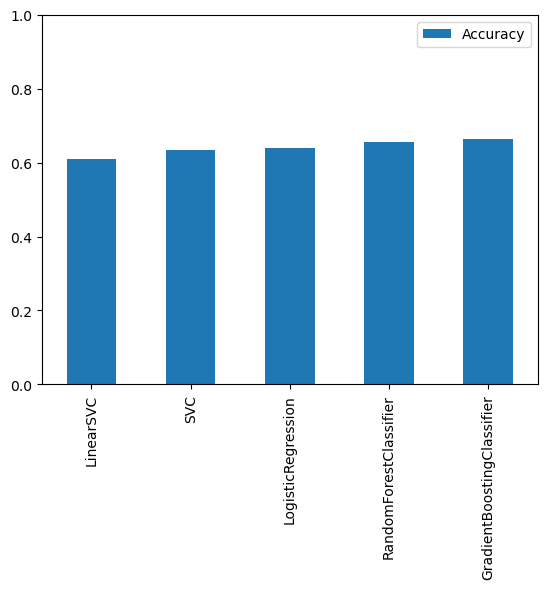

In [52]:
best_estimator = eval(max(results, key=results.get) + "()")
print("The most accurate model is: " + str(best_estimator))

results_df = pd.DataFrame(results.values(), 
                          results.keys(), 
                          columns=["Accuracy"])

print(results_df)

# Create a bar plot of the results dataframe using plot.bar()
ax = results_df.plot.bar()
plt.ylim(0.0, 1.0);

## Hyperparameter Tuning

In [53]:
clf62_pre_tuned = best_estimator

# List the parameters of the best estimator
clf62_pre_tuned.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

## Best Parameter Search

In [54]:
# Import RandomizedSearchCV from sklearn's model_selection module
from sklearn.model_selection import RandomizedSearchCV

## Random Forest Classifier

In [55]:
#Provide wide range of options for parameters for RandomForestClassifier
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


### Linear SVC

In [56]:
# Provide wide number of options for parameters for Linear SVC
#These are the parameters chosen to iterate through.

C = [0.001, 0.01, 0.1, 1, 10]
fit_intercept = [True, False]
class_weight = [None, 'balanced']
random_state = [42, 33, 15, 87]

linear_grid = {'C' : C,
            'fit_intercept': fit_intercept,
            'class_weight': class_weight,
            'random_state': random_state}

### KNN

In [57]:
#provide wide number of options for parameters for kNN

n_neighbors = [x for x in range(3,10)]
weights = ['uniform', 'distance']
algorithm = ['ball_tree', 'kd_tree', 'brute', 'auto']
leaf_size = [x for x in range(10, 110, 10)]

knn_grid = {'n_neighbors': n_neighbors,
            'weights': weights,
            'algorithm': algorithm,
            'leaf_size': leaf_size}

### SVC

In [58]:
#provide wide number of options for parameters for SVC

C = [0.001, 0.01, 0.1, 1, 10]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
degree = [x for x in range(3, 10)]
gamma = ['scale', 'auto']
class_weight = ['balanced', None]
random_state = [42]

svc_grid = {'C': C,
            'kernel': kernel,
            'degree': degree,
            'gamma': gamma,
            'class_weight': class_weight,
            'random_state': random_state}

### Logistic Regression

In [59]:
#provide wide number of options for parameters for Logistic Regression

C = [0.001, 0.01, 0.1, 1, 10]
fit_intercept = [True, False]
class_weight = [None, 'balanced']
random_state = [42]
solver = ['liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs']

logistic_grid = {'C': C,
                 'fit_intercept': fit_intercept,
                 'class_weight': class_weight,
                 'random_state': random_state,
                 'solver': solver}

### Gradient Boosting

In [60]:
#GradientBoosting best param search

loss = ['log_loss', 'exponential']
learning_rate = [0.1]
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 10)]
subsample = [1.0]
criterion = ['friedman_mse', 'squared_error']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
max_features = [None, 'sqrt', 'log2']

GBC_grid = {'loss': loss,
            'learning_rate': learning_rate,
            'n_estimators': n_estimators,
            'subsample': subsample,
            'criterion': criterion,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'max_features': max_features}

## Apply Best Parameter Grids to the Estimator Functions

In [61]:
param_grid = 0

print(type(best_estimator))
if str(best_estimator) == 'LogisticRegression()':
    param_grid = logistic_grid
elif str(best_estimator) == 'KNeighborsClassifier()':
    param_grid = knn_grid
elif str(best_estimator) == 'LinearSVC()':
    param_grid = linear_grid
elif str(best_estimator) == 'SVC()':
    param_grid = svc_grid
elif str(best_estimator) == 'RandomForestClassifier()':
    param_grid = random_grid
elif str(best_estimator) == 'GradientBoostingClassifier()':
    param_grid = GBC_grid

<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>


### Use the Random Grid to Search for Best Parameters

In [62]:
# First create the base model to tune
best_estimator = best_estimator
print(best_estimator)

# Random search of parameters, using 3 fold cross validation; 
# search across 100 different combinations, and use all available cores
tuning = RandomizedSearchCV(estimator = best_estimator, param_distributions = param_grid, n_iter = 25, cv = 3, 
                             verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
search = tuning.fit(X_res_train, y_res_train)

GradientBoostingClassifier()
Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [63]:
#show the best parameters found:
best_params = search.best_params_
best_params

{'subsample': 1.0,
 'n_estimators': 233,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'loss': 'log_loss',
 'learning_rate': 0.1,
 'criterion': 'squared_error'}

In [64]:
#Evaluate these params compared to base params
# Import confusion_matrix and classification_report from sklearn's metrics module
from sklearn.metrics import confusion_matrix, classification_report

# Import precision_score, recall_score and f1_score from sklearn's metrics module
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Base Model Predictions

In [65]:
clf62_pre_tuned.fit(X_res_train, y_res_train)
y_preds = clf62_pre_tuned.predict(X_test)

In [66]:
#Create a confusion matrix using the confusion_matrix function
print(confusion_matrix(y_test_encoded, y_preds))

[[ 522   42  285]
 [ 132 2680  742]
 [ 403  596 1124]]


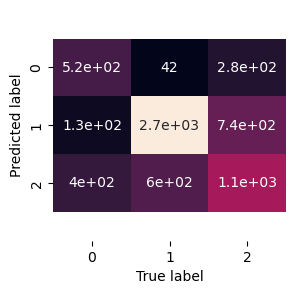

In [67]:
# Import seaborn for improving visualisation of confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make confusion matrix more visual
def plot_conf_mat(y_test_encoded, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test_encoded, y_preds),
                     annot=True, # Annotate the boxes
                     cbar=False)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
    # Fix the broken annotations (this happened in Matplotlib 3.1.1)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5);
    
plot_conf_mat(y_test_encoded, y_preds)
plt.show()

In [68]:
# # Import seaborn for improving visualisation of confusion matrix
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Make confusion matrix more visual
# def plot_conf_mat(y_test, y_preds2):
#     """
#     Plots a confusion matrix using Seaborn's heatmap().
#     """
#     fig, ax = plt.subplots(figsize=(3, 3))
#     ax = sns.heatmap(confusion_matrix(y_test, y_preds2),
#                      annot=True, # Annotate the boxes
#                      cbar=False)
#     plt.xlabel("True label")
#     plt.ylabel("Predicted label")
    
#     # Fix the broken annotations (this happened in Matplotlib 3.1.1)
#     bottom, top = ax.get_ylim()
#     ax.set_ylim(bottom + 0.5, top - 0.5);
    
# plot_conf_mat(y_test, y_preds2)
# plt.show()

## Base Model Classification Report

In [69]:
#classification report
print(classification_report(y_test_encoded, y_preds))

              precision    recall  f1-score   support

           0       0.49      0.61      0.55       849
           1       0.81      0.75      0.78      3554
           2       0.52      0.53      0.53      2123

    accuracy                           0.66      6526
   macro avg       0.61      0.63      0.62      6526
weighted avg       0.67      0.66      0.67      6526



['High' 'Low' 'Moderate']


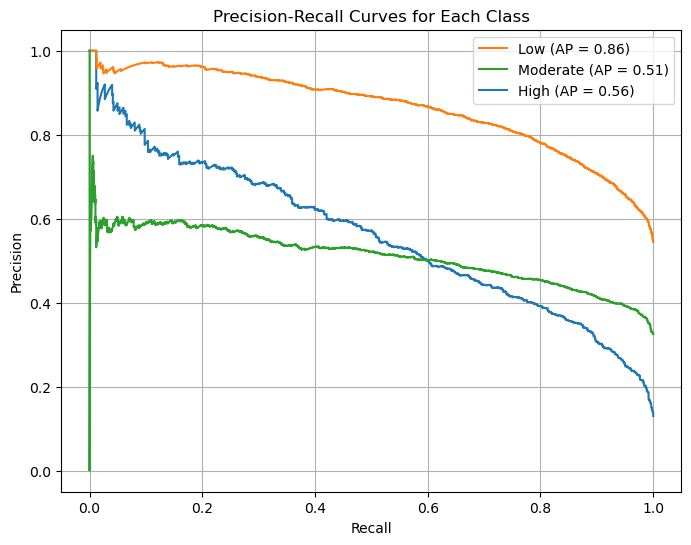

In [70]:
#PR Curves for each class
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

class_names = ['High', 'Low', 'Moderate']

#Get number of classes
n_classes = len(np.unique(y_test_encoded))
print(le.classes_)

#Binarize labels for multi-class PR curve
y_test_bin = label_binarize(y_test_encoded, classes = np.arange(n_classes))

# Get predicted probabilities
y_score = clf62_pre_tuned.predict_proba(X_test)

# Set up the figure
plt.figure(figsize=(8, 6))

# Plot Precision-Recall curve for each class
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])
    
    plt.plot(recall, precision, label=f"{class_names[i]} (AP = {avg_precision:.2f})")

handles, labels = plt.gca().get_legend_handles_labels()
custom_order = [1, 2, 0]

# Plot decorations
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for Each Class")
plt.legend([handles[i] for i in custom_order], [labels[i] for i in custom_order], loc="upper right")
plt.grid()
plt.show()

## Base Model Cross-Validation Score

In [71]:
# Import cross_val_score from sklearn's model_selection module
from sklearn.model_selection import cross_val_score

In [72]:
cross_val_score(clf62_pre_tuned, 
                X_test, 
                y_test_encoded, 
                scoring="accuracy",
                cv=5)

array([0.66232772, 0.66590038, 0.67739464, 0.68505747, 0.66743295])

In [73]:
cross_val_pre_tuned = np.mean(cross_val_score(clf62_pre_tuned,
                                        X_test,
                                        y_test_encoded,
                                        scoring="accuracy",
                                        cv=5))

cross_val_pre_tuned

0.6713161183573604

## Tuned Model Predictions

In [74]:
print(best_estimator)
best_params

GradientBoostingClassifier()


{'subsample': 1.0,
 'n_estimators': 233,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'loss': 'log_loss',
 'learning_rate': 0.1,
 'criterion': 'squared_error'}

In [75]:
#Evaluating model with tuned parameters:

clf62_tuned = GradientBoostingClassifier(subsample = 1.0,
                                        n_estimators = 233,
                                        min_samples_split = 5,
                                        min_samples_leaf = 1,
                                        max_features = 'log2',
                                        loss = 'log_loss',
                                        learning_rate = 0.1,
                                        criterion = 'squared_error')

### Fit the Tuned Model

In [76]:
clf62_tuned.fit(X_res_train, y_res_train)

GradientBoostingClassifier(criterion='squared_error', max_features='log2',
                           min_samples_split=5, n_estimators=233)

### Tuned Model Predictions

In [77]:
y_preds62_tuned = clf62_tuned.predict(X_test)

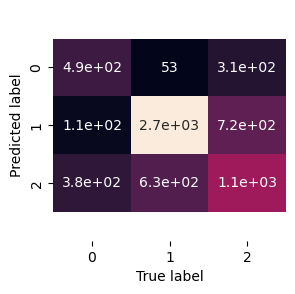

In [78]:
# Make confusion matrix more visual
def plot_conf_mat(y_test_encoded, y_preds62_tuned):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test_encoded, y_preds62_tuned),
                     annot=True, # Annotate the boxes
                     cbar=False)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
    # Fix the broken annotations (this happened in Matplotlib 3.1.1)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5);
    
plot_conf_mat(y_test_encoded, y_preds62_tuned)
plt.show()

[0.05301394 0.14973524 0.04202725 0.1486338  0.04570088 0.06201949
 0.02244634 0.11859986 0.3476345  0.01018871]
Index(['number_of_attended_app', 'Depression62', 'Eating62', 'Anxiety62',
       'Hostility62', 'Social_Anxiety62', 'Family62', 'Academics62', 'DI',
       'SDS_90'],
      dtype='object')
                        importance
number_of_attended_app    0.053014
Depression62              0.149735
Eating62                  0.042027
Anxiety62                 0.148634
Hostility62               0.045701
Social_Anxiety62          0.062019
Family62                  0.022446
Academics62               0.118600
DI                        0.347634
SDS_90                    0.010189


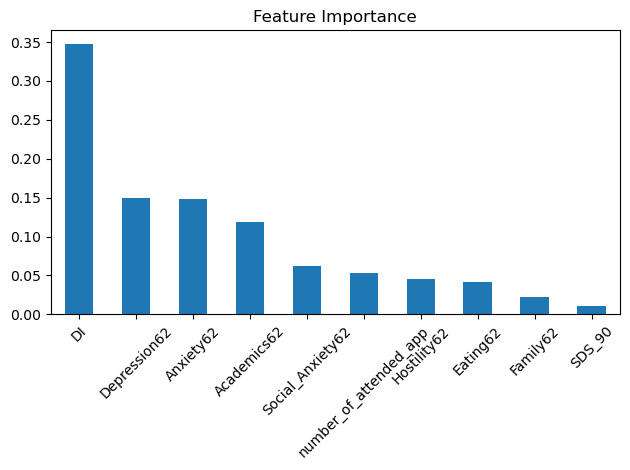

In [79]:
#Find feature importances
feature_imps = clf62_tuned.feature_importances_
print(feature_imps)
print(X.columns)
feature_dict =dict(zip(X.columns, list(feature_imps)))
feature_dict

# #Visualize feature importance
feature_df = pd.DataFrame(feature_imps, index = X.columns, columns=['importance'])
print(feature_df)
feature_df_sorted = feature_df.sort_values(by='importance', ascending=False)

feature_df_sorted.plot.bar(title="Feature Importance", legend = False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [80]:
#obtain cross_val score for tuned model
cross_val62_tuned = np.mean(cross_val_score(clf62_tuned,
                                        X_test,
                                        y_test_encoded,
                                        scoring="accuracy",
                                        cv=5))

cross_val62_tuned

0.6624265253794747

In [81]:
#Improvement as a result of hyperparameter tuning
print('Improvement of {:0.2f}%.'.format( 100 * (cross_val62_tuned - cross_val_pre_tuned) / cross_val_pre_tuned))

Improvement of -1.32%.


In [82]:
#Classification Report on tuned predictions
print(classification_report(y_test_encoded, y_preds62_tuned))
print(le.classes_)

              precision    recall  f1-score   support

           0       0.50      0.57      0.53       849
           1       0.80      0.77      0.78      3554
           2       0.52      0.53      0.52      2123

    accuracy                           0.66      6526
   macro avg       0.61      0.62      0.61      6526
weighted avg       0.67      0.66      0.67      6526

['High' 'Low' 'Moderate']


###  CCAPS 62 MLM Trial yielded unacceptable accuracy for Moderate and High Categories

In [83]:

df_Xy = X.copy()
df_Xy['post_tx_DI'] = post_tx_data_62['DI'].values
print(post_tx_data_62['DI'].shape)
print(post_tx_data_62['DI'].isnull().sum())
print(post_tx_data_62['DI'].dtype)
print(df_Xy.tail())
print(df_Xy['DI'].isna().sum())
print(df_Xy['post_tx_DI'].isna().sum())

(26102,)
0
float64
       number_of_attended_app  Depression62  Eating62  Anxiety62  Hostility62  \
87062                       2      2.076923  0.111111   1.777778     2.285714   
87064                       3      2.692308  2.625000   2.888889     1.571429   
87066                       3      2.615385  3.444444   2.111111     0.142857   
87068                       2      3.153846  0.333333   3.777778     1.571429   
87070                       2      2.230769  1.111111   1.333333     1.142857   

       Social_Anxiety62  Family62  Academics62    DI  SDS_90  post_tx_DI  
87062          0.142857  1.666667          0.8  1.60     1.0        0.65  
87064          1.714286  3.000000          2.4  2.75     1.0        2.40  
87066          2.428571  1.166667          0.2  2.10     1.0        1.75  
87068          1.285714  3.333333          1.4  2.95     1.0        1.25  
87070          2.428571  1.500000          3.2  1.90     1.0        1.80  
0
0


In [84]:
#Let's look at some correlations between non-zero coef. features and post-tx DI

from scipy.stats import pearsonr

def plot_feature_scatter_grid(data, features, target, n_cols = 3):
    n_features = len(features)
    n_rows = (n_features + n_cols - 1) // n_cols
    
    plt.figure(figsize = (n_cols * 5, n_rows *6))
    
    for i, feature in enumerate(features):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.scatterplot(x = data[feature], y=data[target], alpha=0.6)
        
        if data[feature].dtype.kind in 'bifc':
            corr, _ = pearsonr(data[feature], data[target])
            plt.title(f'{feature}\nPearson r = {corr:.2f}')
        else:
            plt.title(f"{feature}\n(non-numeric)")
    
    plt.tight_layout()
    plt.show()

In [85]:
features = df_Xy.columns[:].tolist()
print(features)
target = 'post_tx_DI'
print(target)

['number_of_attended_app', 'Depression62', 'Eating62', 'Anxiety62', 'Hostility62', 'Social_Anxiety62', 'Family62', 'Academics62', 'DI', 'SDS_90', 'post_tx_DI']
post_tx_DI


In [86]:
print(df_Xy.isna().sum())
print(np.isinf(df_Xy).sum())

# Find null feature values (if any) and replace with zero, median, or mean, as appropriate.
print(f'Null values for features: {df_Xy.isna().sum()}')
df_Xy.fillna(X.median(numeric_only=True), inplace=True)
print(f'Null values for features: {df_Xy.isna().sum()}')

number_of_attended_app    0
Depression62              0
Eating62                  0
Anxiety62                 0
Hostility62               0
Social_Anxiety62          0
Family62                  0
Academics62               0
DI                        0
SDS_90                    0
post_tx_DI                0
dtype: int64
number_of_attended_app    0
Depression62              0
Eating62                  0
Anxiety62                 0
Hostility62               0
Social_Anxiety62          0
Family62                  0
Academics62               0
DI                        0
SDS_90                    0
post_tx_DI                0
dtype: int64
Null values for features: number_of_attended_app    0
Depression62              0
Eating62                  0
Anxiety62                 0
Hostility62               0
Social_Anxiety62          0
Family62                  0
Academics62               0
DI                        0
SDS_90                    0
post_tx_DI                0
dtype: int64
Null values

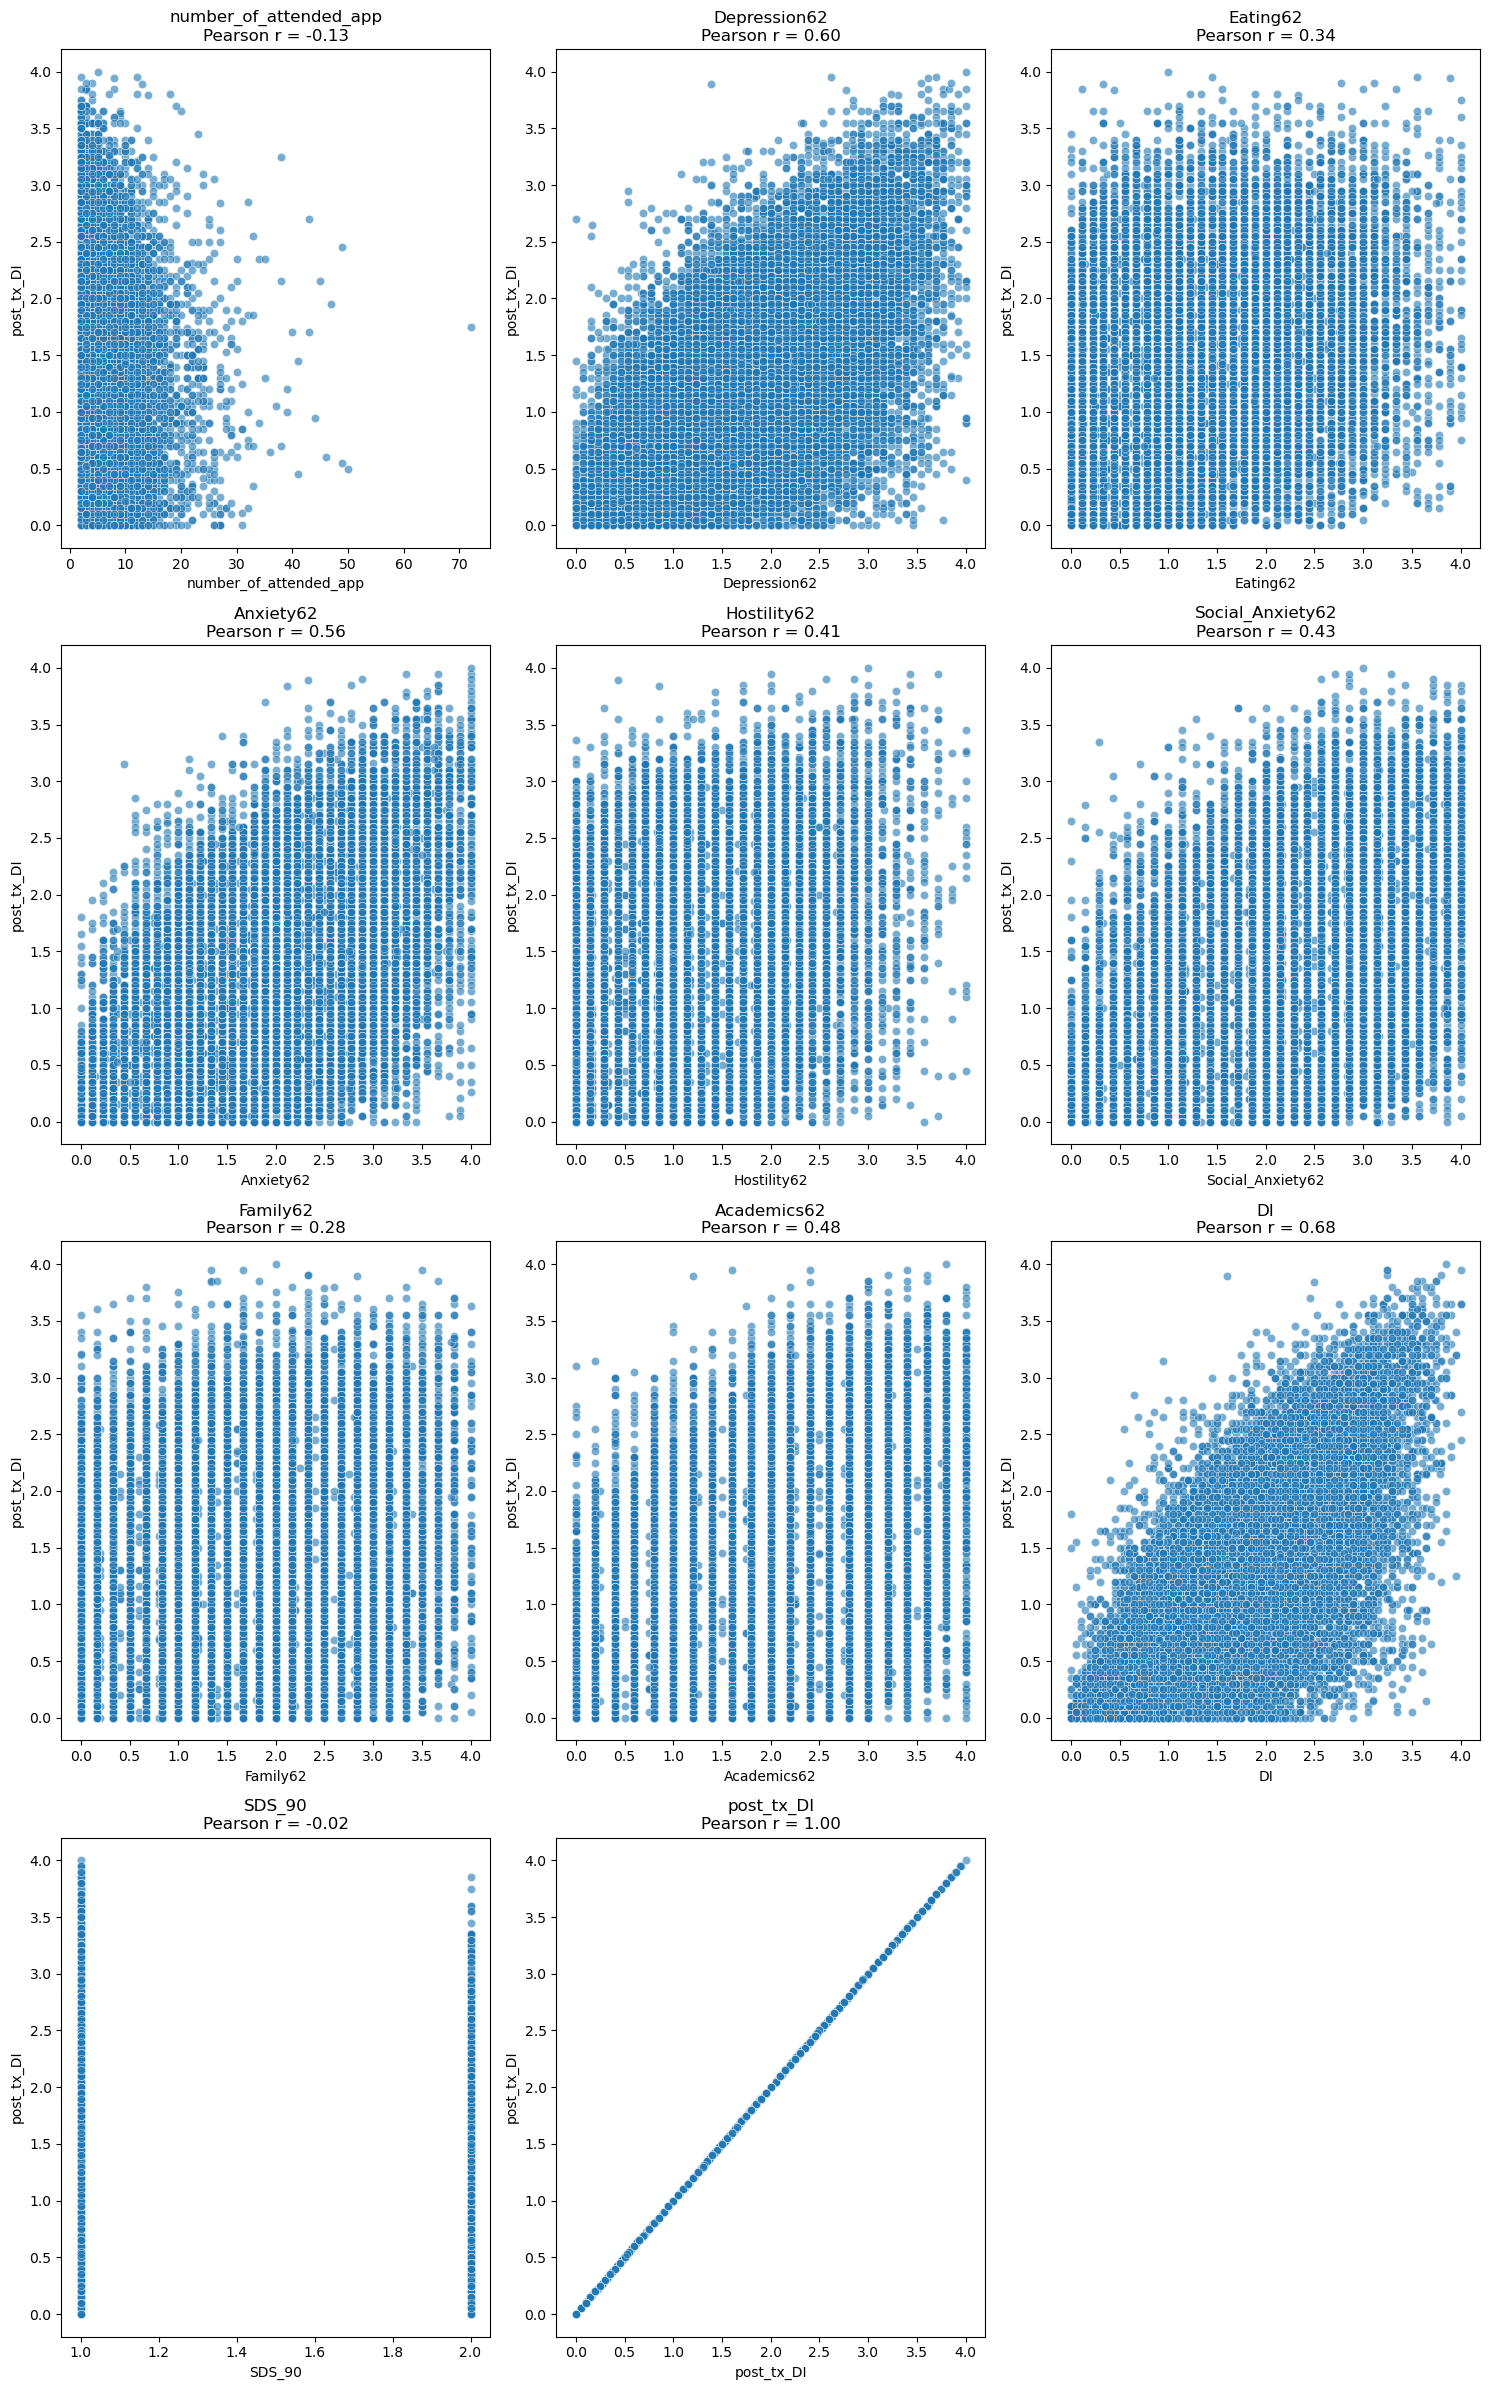

In [87]:
plot_feature_scatter_grid(data=df_Xy, features = features, target = target)

In [88]:
ccaps = str('CCAPS')
num = [f'{i:02}' for i in range(1, 71)]
labeled = [f"CCAPS_{i}" for i in num]


my_list = labeled

items_to_remove = ['CCAPS_02', 'CCAPS_07', 'CCAPS_12', 'CCAPS_20', 'CCAPS_42', 'CCAPS_55', 'CCAPS_62', 'CCAPS_67']

final_list = [item for item in my_list if item not in items_to_remove]
print(final_list)


['CCAPS_01', 'CCAPS_03', 'CCAPS_04', 'CCAPS_05', 'CCAPS_06', 'CCAPS_08', 'CCAPS_09', 'CCAPS_10', 'CCAPS_11', 'CCAPS_13', 'CCAPS_14', 'CCAPS_15', 'CCAPS_16', 'CCAPS_17', 'CCAPS_18', 'CCAPS_19', 'CCAPS_21', 'CCAPS_22', 'CCAPS_23', 'CCAPS_24', 'CCAPS_25', 'CCAPS_26', 'CCAPS_27', 'CCAPS_28', 'CCAPS_29', 'CCAPS_30', 'CCAPS_31', 'CCAPS_32', 'CCAPS_33', 'CCAPS_34', 'CCAPS_35', 'CCAPS_36', 'CCAPS_37', 'CCAPS_38', 'CCAPS_39', 'CCAPS_40', 'CCAPS_41', 'CCAPS_43', 'CCAPS_44', 'CCAPS_45', 'CCAPS_46', 'CCAPS_47', 'CCAPS_48', 'CCAPS_49', 'CCAPS_50', 'CCAPS_51', 'CCAPS_52', 'CCAPS_53', 'CCAPS_54', 'CCAPS_56', 'CCAPS_57', 'CCAPS_58', 'CCAPS_59', 'CCAPS_60', 'CCAPS_61', 'CCAPS_63', 'CCAPS_64', 'CCAPS_65', 'CCAPS_66', 'CCAPS_68', 'CCAPS_69', 'CCAPS_70']


### Compare this MLM to base Model predicting Low category only

In [89]:
from sklearn.metrics import classification_report
import pandas as pd

# Use the pre‑treatment *category* column
pre_categories = pre_tx_data_62['Pre_tx_Categories']          # 'Low' / 'Moderate' / 'High'
y_pred_baseline = ['Low' if cat == 'Low' else None for cat in pre_categories]

# Align with the matching post‑treatment categories
y_true = pre_and_post_DIs['Post_tx_Categories']



# keep rows where we predicted and the true label is not NaN
mask = (pd.Series(y_pred_baseline).notna()) & (y_true.notna())

# now everything passed to classification_report is a string
print(classification_report(y_true[mask], pd.Series(y_pred_baseline)[mask],
                            labels=['Low'])) 


              precision    recall  f1-score   support

         Low       0.90      1.00      0.95      6420

   micro avg       0.90      1.00      0.95      6420
   macro avg       0.90      1.00      0.95      6420
weighted avg       0.90      1.00      0.95      6420



In [90]:
print(X_res_train.head())
print(y_res_train)

   number_of_attended_app  Depression62  Eating62  Anxiety62  Hostility62  \
0                       4      2.769231  0.555556   1.666667     1.285714   
1                       2      2.230769  2.222222   2.888889     0.714286   
2                       4      2.846154  1.888889   3.222222     2.428571   
3                       2      3.000000  1.777778   3.222222     3.142857   
4                      14      3.000000  2.777778   1.333333     0.571429   

   Social_Anxiety62  Family62  Academics62    DI  SDS_90  
0          2.166667  1.333333          3.8  2.80     2.0  
1          3.571429  0.666667          2.0  2.55     1.0  
2          2.571429  2.000000          3.2  2.95     1.0  
3          2.285714  3.200000          2.0  2.90     1.0  
4          1.857143  0.166667          2.0  2.25     1.0  
[2 2 2 ... 2 2 2]


In [91]:
#Base Model that predicts the pre_tx DI category will be the same as the post_tx DI category:
from sklearn.metrics import classification_report
import pandas as pd

# print(y_test_encoded) #post-DI data
# you need the pre-DI encoded data of the test dataset (DI of X test)
#encode the pre-treatment DI data

pre_tx_DI_train_data = X_res_train.loc[:, 'Pre_tx_DI_train_data'] = pd.cut(x = X_res_train['DI'], bins = [-0.01, 1.30, 2.25, 4.0], 
                                     labels = ['Low', 'Moderate' , 'High'])
labels = np.array(["High", "Low", "Moderate"])
y_res_train_mapped = labels[y_res_train].tolist()

# print(pre_tx_DI_train_data.head())
# print(f'Y_train unmapped: {y_res_train}')
# print(f'Y_train: {y_res_train_mapped}')
#print(X_test['DI'])
# Pre‑ and post‑treatment category columns
#print(X_res_train)
pre_categories  = pre_tx_DI_train_data #pre_tx_data_62['Pre_tx_Categories']   # 'Low' / 'Moderate' / 'High'
y_true          = y_res_train_mapped


# Baseline prediction: keep the same label
y_pred_baseline = pre_categories.copy()                 # predicts 'Low'→'Low', 'Moderate'→'Moderate', …

pre_categories = pd.Series(pre_categories)
y_true = pd.Series(y_true)
# Drop rows where either side is missing
mask = pre_categories.notna() & y_true.notna()

# Classification report for all three classes

print(
    classification_report(
        y_true[mask],
        y_pred_baseline[mask],
        labels=['Low', 'Moderate', 'High']
    )
)


              precision    recall  f1-score   support

         Low       0.85      0.45      0.59     10516
    Moderate       0.47      0.52      0.49     10516
        High       0.62      0.83      0.71     10516

    accuracy                           0.60     31548
   macro avg       0.65      0.60      0.60     31548
weighted avg       0.65      0.60      0.60     31548



In [92]:
#Do the same for the test set
import pandas as pd
from sklearn.metrics import classification_report

# Step 1. Bin pre-treatment DI values in the test set
pre_tx_DI_test_data = pd.cut(
    x=X_test['DI'],
    bins=[-0.01, 1.30, 2.25, 4.0],
    labels=['Low', 'Moderate', 'High']
)

# Step 2. Map y_test integers into category labels
mapping = {0: "High", 1: "Low", 2: "Moderate"}  # <-- adjust if encoding is different
y_test_mapped = pd.Series(y_test_encoded).map(mapping)

# Step 3. Apply baseline: predict pre = post
y_pred_baseline = pre_tx_DI_test_data.copy()

# Step 4. Convert to Series (and strings for consistency)
# pre_categories = pd.Series(pre_tx_DI_test_data).astype(str)
# y_true = pd.Series(y_test_mapped).astype(str)

pre_categories = pd.Series(pre_tx_DI_test_data).astype(str).reset_index(drop=True)
y_true = pd.Series(y_test_mapped).astype(str).reset_index(drop=True)

mask = pre_categories.notna() & y_true.notna()
print("Mask sum (should equal 6526):", mask.sum())


# Step 5. Drop rows with missing values
mask = pre_categories.notna() & y_true.notna()

# Debug: show what values exist
print("Unique values in y_true:", y_true[mask].unique())
print("Unique values in predictions:", pre_categories[mask].unique())

# Step 6. Classification report on the TEST set
print(
    classification_report(
        y_true[mask],
        pre_categories[mask],
    )
)

print("Total rows in X_test:", len(X_test))
print("Rows with valid pre-categories:", pre_categories.notna().sum())
print("Rows with valid y_true:", y_true.notna().sum())
print("Rows after mask:", mask.sum())

print("Unique values in y_test_encoded:", pd.Series(y_test_encoded).unique())



Mask sum (should equal 6526): 6526
Unique values in y_true: ['High' 'Low' 'Moderate']
Unique values in predictions: ['High' 'Low' 'Moderate']
              precision    recall  f1-score   support

        High       0.36      0.82      0.50       849
         Low       0.89      0.46      0.61      3554
    Moderate       0.39      0.51      0.44      2123

    accuracy                           0.52      6526
   macro avg       0.55      0.60      0.52      6526
weighted avg       0.66      0.52      0.54      6526

Total rows in X_test: 6526
Rows with valid pre-categories: 6526
Rows with valid y_true: 6526
Rows after mask: 6526
Unique values in y_test_encoded: [0 1 2]


=== TRAINING SET CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

         Low       0.85      0.45      0.59     10516
    Moderate       0.47      0.52      0.49     10516
        High       0.62      0.83      0.71     10516

    accuracy                           0.60     31548
   macro avg       0.65      0.60      0.60     31548
weighted avg       0.65      0.60      0.60     31548

=== TEST SET CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

         Low       0.89      0.46      0.61      3554
    Moderate       0.39      0.51      0.44      2123
        High       0.36      0.82      0.50       849

    accuracy                           0.52      6526
   macro avg       0.55      0.60      0.52      6526
weighted avg       0.66      0.52      0.54      6526



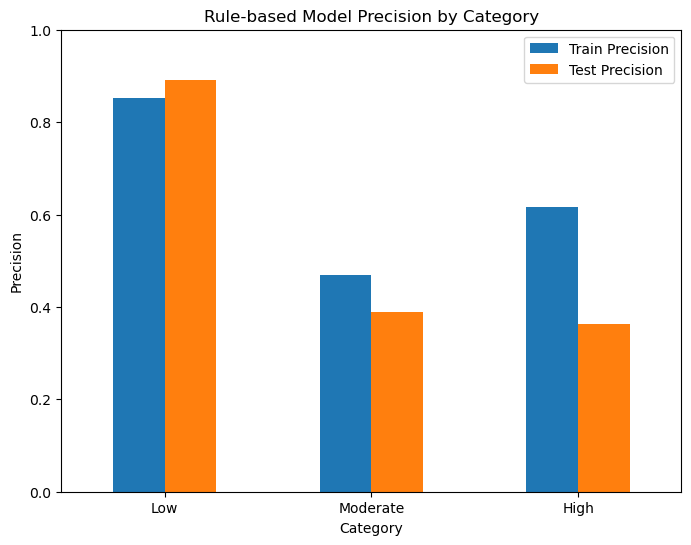

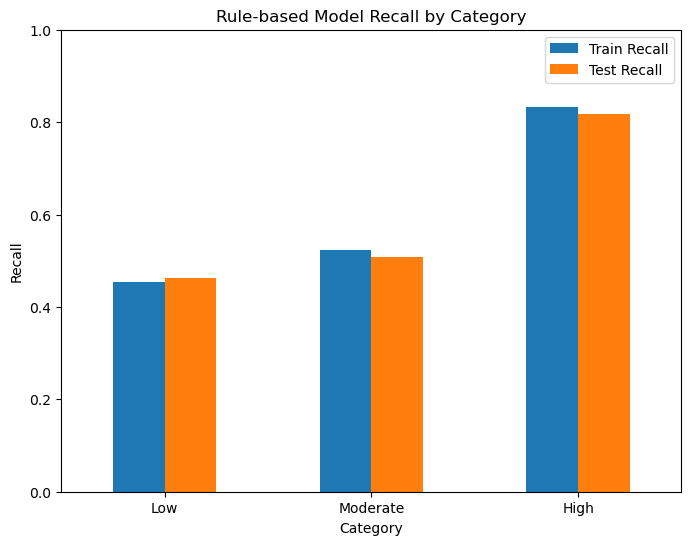

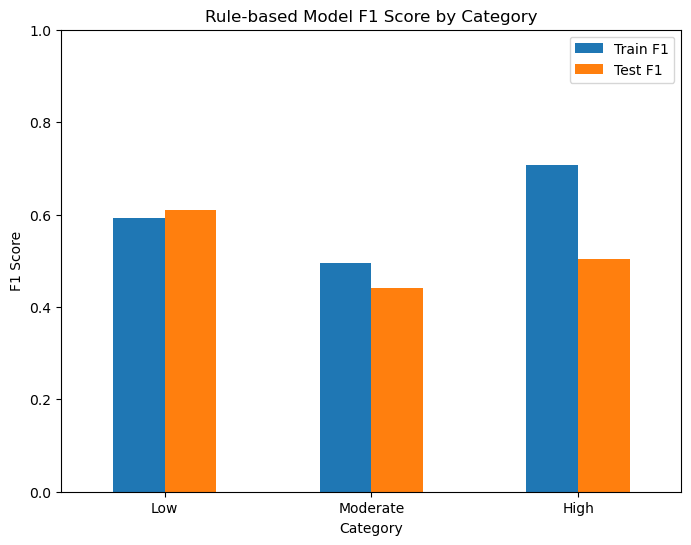

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# -----------------------------
# 1. TRAINING SET EVALUATION
# -----------------------------

# Bin pre-treatment DI values in training set
pre_tx_DI_train_data = pd.cut(
    x=X_res_train['DI'],
    bins=[-0.01, 1.30, 2.25, 4.0],
    labels=['Low', 'Moderate', 'High']
)

# Map training labels from integers to strings
labels_array = np.array(["High", "Low", "Moderate"])
y_res_train_mapped = pd.Series(labels_array[y_res_train]).astype(str).reset_index(drop=True)

# Convert pre-treatment categories to string and reset index
pre_categories_train = pd.Series(pre_tx_DI_train_data).astype(str).reset_index(drop=True)

# Baseline prediction: pre = post
y_pred_train_baseline = pre_categories_train.copy()

# Mask to drop any missing values (safe)
mask_train = pre_categories_train.notna() & y_res_train_mapped.notna()

# Classification report for training set
train_report = classification_report(
    y_res_train_mapped[mask_train],
    y_pred_train_baseline[mask_train],
    labels=['Low', 'Moderate', 'High'],
    output_dict=True
)

print("=== TRAINING SET CLASSIFICATION REPORT ===")
print(classification_report(
    y_res_train_mapped[mask_train],
    y_pred_train_baseline[mask_train],
    labels=['Low', 'Moderate', 'High']
))

# -----------------------------
# 2. TEST SET EVALUATION
# -----------------------------

# Bin pre-treatment DI values in test set
pre_tx_DI_test_data = pd.cut(
    x=X_test['DI'],
    bins=[-0.01, 1.30, 2.25, 4.0],
    labels=['Low', 'Moderate', 'High']
)

# Map test labels from integers to strings
mapping_test = {0: "High", 1: "Low", 2: "Moderate"}
y_test_mapped = pd.Series(y_test_encoded).map(mapping_test).astype(str).reset_index(drop=True)

# Convert pre-treatment categories to string and reset index
pre_categories_test = pd.Series(pre_tx_DI_test_data).astype(str).reset_index(drop=True)

# Baseline prediction: pre = post
y_pred_test_baseline = pre_categories_test.copy()

# Mask to drop missing values
mask_test = pre_categories_test.notna() & y_test_mapped.notna()

# Classification report for test set
test_report = classification_report(
    y_test_mapped[mask_test],
    y_pred_test_baseline[mask_test],
    labels=['Low', 'Moderate', 'High'],
    output_dict=True
)

print("=== TEST SET CLASSIFICATION REPORT ===")
print(classification_report(
    y_test_mapped[mask_test],
    y_pred_test_baseline[mask_test],
    labels=['Low', 'Moderate', 'High']
))

# -----------------------------
# 3. PER-CATEGORY RECALL AND F1 SCORE PLOT
# -----------------------------

labels_order = ['Low', 'Moderate', 'High']

# Extract recall and F1 scores for each category
train_recall = [train_report[label]['recall'] for label in labels_order]
train_f1 = [train_report[label]['f1-score'] for label in labels_order]
train_precision = [train_report[label]['precision'] for label in labels_order]

test_recall = [test_report[label]['recall'] for label in labels_order]
test_f1 = [test_report[label]['f1-score'] for label in labels_order]
test_precision = [test_report[label]['precision'] for label in labels_order]

# Create DataFrame for plotting
plot_df = pd.DataFrame({
    "Category": labels_order,
    "Train Recall": train_recall,
    "Test Recall": test_recall,
    "Train Precision": train_precision,
    "Test Precision": test_precision,
    "Train F1": train_f1,
    "Test F1": test_f1
})

#Plot precision score side by side
plot_df.plot(x="Category", y=["Train Precision", "Test Precision"], kind="bar", figsize=(8,6))
plt.ylabel("Precision")
plt.title("Rule-based Model Precision by Category")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.show()

# Plot recall side by side
plot_df.plot(x="Category", y=["Train Recall", "Test Recall"], kind="bar", figsize=(8,6))
plt.ylabel("Recall")
plt.title("Rule-based Model Recall by Category")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.show()

# Plot F1 score side by side
plot_df.plot(x="Category", y=["Train F1", "Test F1"], kind="bar", figsize=(8,6))
plt.ylabel("F1 Score")
plt.title("Rule-based Model F1 Score by Category")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.show()


In [94]:
#Classification Report on tuned predictions
print(classification_report(y_test_encoded, y_preds62_tuned))
print(le.classes_)

              precision    recall  f1-score   support

           0       0.50      0.57      0.53       849
           1       0.80      0.77      0.78      3554
           2       0.52      0.53      0.52      2123

    accuracy                           0.66      6526
   macro avg       0.61      0.62      0.61      6526
weighted avg       0.67      0.66      0.67      6526

['High' 'Low' 'Moderate']


In [95]:
# 1. Ensure y_true corresponds to the same dataset as X_res_train
# For example, if you’re using X_res_train, y_res_train should be aligned
y_post = y_res_train  # post-treatment labels aligned with X_res_train

# 2. Get code for "High"
high_code = np.where(le.classes_ == "High")[0][0]

# 3. Pre-treatment mask
mask_pre_high = X_res_train['DI'] >= 2.25

# 4. Calculate proportion staying High
pct_stayed_high = np.mean(y_post[mask_pre_high] == high_code) * 100

print(f"Percentage of pre-treatment High that stayed High: {pct_stayed_high:.2f}%")



Percentage of pre-treatment High that stayed High: 60.23%


In [96]:
# So far, the trained model is better than the rule model for Moderate (.05 better) and High (.02 better) Categories,
# though arguably, the rule model is better for High category because the recall score (false negatives) are fewer. 
# Likewise, the base model is better for 'Low' category because precision is more important than recall.  False negatives
# in the 'Low' category do not pose a risk, but false positives are dangerous.

#Expected accuracy of guessing among three categories with consideration of distribution of categories (54% Low, 33% Moderate, 13% High):  .54^2 + .33^2 + .13^2 = .42 or 42
#Therefore, the trained model is overall better than guessing among the three categories without consideration of pre-treatment scores.

In [97]:
from sklearn.metrics import f1_score
import numpy as np

print(f'pred_baseline length: {len(y_pred_baseline)}')
print(f'y_preds length: {len(y_preds)}')
print(f'y_test_encoded length: {len(y_test_encoded)}')

y_baseline_sample = y_pred_baseline.sample(n=6526)

y_test_encoded_arr = y_test_encoded.to_numpy() if hasattr(y_test_encoded, 'to_numpy') else np.array(y_test_encoded)
y_baseline_sample_arr = y_baseline_sample.to_numpy() if hasattr(y_baseline_sample, 'to_numpy') else np.array(y_baseline_sample)
y_preds_arr = y_preds.to_numpy() if hasattr(y_preds, 'to_numpy') else np.array(y_preds)

# Map categories to numbers
mapping = {"High": 0, "Low": 1, "Moderate": 2}
y_baseline_sample_arr_nums = np.array([mapping[item] for item in y_baseline_sample_arr], dtype=np.int32)

# Function to compute bootstrap CIs and exact difference
def bootstrap_f1_diff(y_true, y_base, y_ml, label, n_iterations=1000):
    diffs = []

    # Exact F1 difference (no bootstrapping)
    f1_base_exact = f1_score(y_true, y_base, labels=[label], average=None)[0]
    f1_ml_exact = f1_score(y_true, y_ml, labels=[label], average=None)[0]
    exact_diff = f1_ml_exact - f1_base_exact

    # Bootstrap resampling
    for _ in range(n_iterations):
        sample_idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        f1_base = f1_score(y_true[sample_idx], y_base[sample_idx], labels=[label], average=None)[0]
        f1_ml = f1_score(y_true[sample_idx], y_ml[sample_idx], labels=[label], average=None)[0]
        diffs.append(f1_ml - f1_base)

    diffs = np.array(diffs)
    ci_lower, ci_upper = np.percentile(diffs, [2.5, 97.5])

    return exact_diff, ci_lower, ci_upper

# Moderate
diff, ci_lower, ci_upper = bootstrap_f1_diff(y_test_encoded_arr, y_baseline_sample_arr_nums, y_preds_arr, label=2)
print(f"'Moderate' F1 Δ = {diff:.4f}, 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
if ci_lower > 0:
    print("ML model is significantly better on 'Moderate'.")
elif ci_upper < 0:
    print("Base model is significantly better on 'Moderate'.")
else:
    print("No significant difference on 'Moderate'.")

# High
diff, ci_lower, ci_upper = bootstrap_f1_diff(y_test_encoded_arr, y_baseline_sample_arr_nums, y_preds_arr, label=0)
print(f"'High' F1 Δ = {diff:.4f}, 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
if ci_lower > 0:
    print("ML model is significantly better on 'High'.")
elif ci_upper < 0:
    print("Base model is significantly better on 'High'.")
else:
    print("No significant difference on 'High'.")

# Low
diff, ci_lower, ci_upper = bootstrap_f1_diff(y_test_encoded_arr, y_baseline_sample_arr_nums, y_preds_arr, label=1)
print(f"'Low' F1 Δ = {diff:.4f}, 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
if ci_lower > 0:
    print("ML model is significantly better on 'Low'.")
elif ci_upper < 0:
    print("Base model is significantly better on 'Low'.")
else:
    print("No significant difference on 'Low'.")


pred_baseline length: 6526
y_preds length: 6526
y_test_encoded length: 6526
'Moderate' F1 Δ = 0.1688, 95% CI: [0.1468, 0.1918]
ML model is significantly better on 'Moderate'.
'High' F1 Δ = 0.3551, 95% CI: [0.3250, 0.3848]
ML model is significantly better on 'High'.
'Low' F1 Δ = 0.4080, 95% CI: [0.3895, 0.4269]
ML model is significantly better on 'Low'.
